In [1]:
import os
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
COLORS = sns.color_palette('colorblind')

## Content Table:
* [Data Metrics](#1-bullet)
* [Basic Model Metrics](#2-bullet)
* [Cross Model Metrics](#3-bullet)

In [2]:
if os.getenv('CONTAINER_BASE_DIR'):
    API_DIRECTORY_URL = 'http://api:8080/'
    directory = requests.get(API_DIRECTORY_URL).json()
    directory['result'] = {k: v.replace('localhost', 'api') 
                           for k, v in directory['result'].items()}
else:
    API_DIRECTORY_URL = 'http://localhost:8080/'
    directory = requests.get(API_DIRECTORY_URL).json()

In [3]:
raw_df_data = requests.get(directory['result']['get_dataframe_data']).json()
raw_model_data = requests.get(directory['result']['get_model_data']).json()
raw_cross_data = requests.get(directory['result']['get_cross_model_data']).json()

## Data Metrics <a class="anchor" id="1-bullet"></a>

In [4]:
data_to_create_df = []
for record in raw_df_data['result']:
    data_to_create_df = data_to_create_df + record['message']['data']

In [5]:
df_data = pd.DataFrame(data_to_create_df)

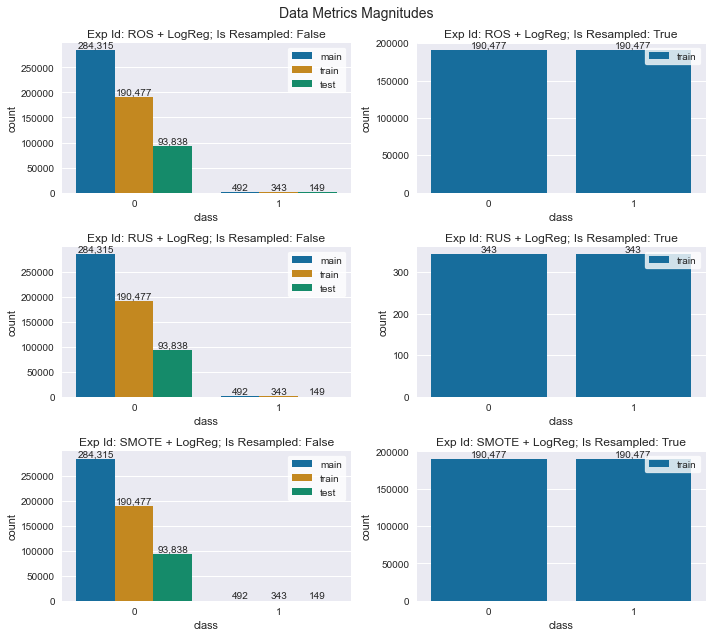

In [6]:
_ = plt.figure(figsize=[10, 9])
plt.suptitle('Data Metrics Magnitudes', fontsize=14)

for i, exp in enumerate(df_data['exp_id'].unique()[:3]):
    data = df_data[df_data['exp_id'] == exp]
    
    index = (i * 2) + 1
    
    plt.subplot(3,2,index)
    ros_log_original = data[~data['is_resampled']]
    ax = sns.barplot(
        data=ros_log_original, 
        x='class', 
        y='count',
        hue='subset',
        palette='colorblind')
    for container in ax.containers:
        labels = [f'{int(value):,}' for value in container.datavalues]
        ax.bar_label(container, labels)
    ax.set_ylabel('count')
    plt.title(f'Exp Id: {exp}; Is Resampled: False')
    legend = plt.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_color('white')

    plt.subplot(3,2,index+1)
    ros_log_resampled = data[data['is_resampled']]
    ax = sns.barplot(
        data=ros_log_resampled, 
        x='class', 
        y='count',
        hue='subset',
        palette='colorblind')
    for container in ax.containers:
        labels = [f'{int(value):,}' for value in container.datavalues]
        ax.bar_label(container, labels)
    ax.set_ylabel('count')
    plt.title(f'Exp Id: {exp}; Is Resampled: True')
    legend = plt.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_color('white')

plt.tight_layout()

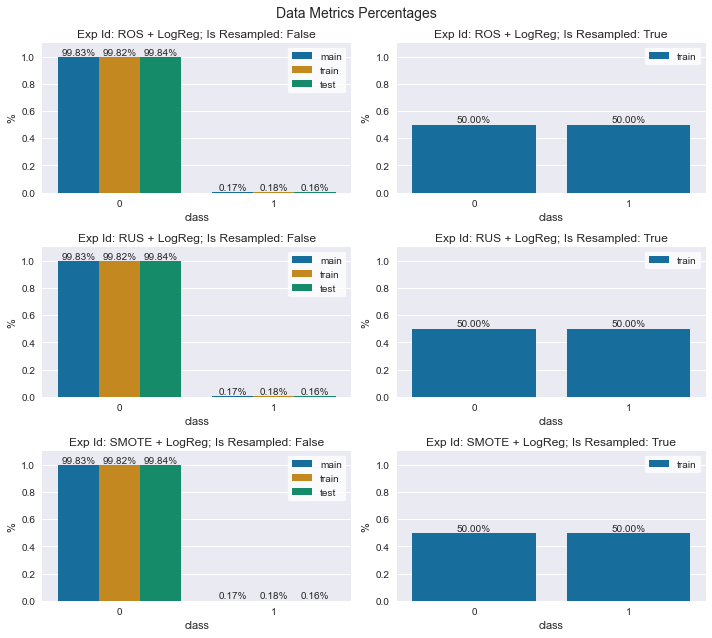

In [7]:
_ = plt.figure(figsize=[10, 9])
plt.suptitle('Data Metrics Percentages', fontsize=14)

for i, exp in enumerate(df_data['exp_id'].unique()[:3]):
    data = df_data[df_data['exp_id'] == exp]
    
    index = (i * 2) + 1
    
    plt.subplot(3,2,index)
    ros_log_original = data[~data['is_resampled']]
    ax = sns.barplot(
        data=ros_log_original, 
        x='class', 
        y='percent',
        hue='subset',
        palette='colorblind')
    for container in ax.containers:
        labels = [f'{value:.2f}%' for value in container.datavalues*100]
        ax.bar_label(container, labels)
    ax.set_ylabel('%')
    plt.ylim([0, 1.1])
    plt.title(f'Exp Id: {exp}; Is Resampled: False')
    legend = plt.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_color('white')

    plt.subplot(3,2,index+1)
    ros_log_resampled = data[data['is_resampled']]
    ax = sns.barplot(
        data=ros_log_resampled, 
        x='class', 
        y='percent',
        hue='subset',
        palette='colorblind')
    for container in ax.containers:
        labels = [f'{value:.2f}%' for value in container.datavalues*100]
        ax.bar_label(container, labels)
    ax.set_ylabel('%')
    plt.ylim([0, 1.1])
    plt.title(f'Exp Id: {exp}; Is Resampled: True')
    legend = plt.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_color('white')

plt.tight_layout()

## Basic Model Metrics <a class="anchor" id="2-bullet"></a>

In [8]:
data_to_create_df = [record['message']['data'] for record in raw_model_data['result']]
df_model_metric = pd.DataFrame(data_to_create_df)

In [9]:
df_model_metric.drop_duplicates(subset='f_score', keep='first', inplace=True)

for exp in ['LogReg', 'RanFor']:
    mask = (~df_model_metric['is_resampled']) & (df_model_metric['exp_id'].str.contains(exp))
    df_model_metric.loc[mask, 'exp_id'] = exp

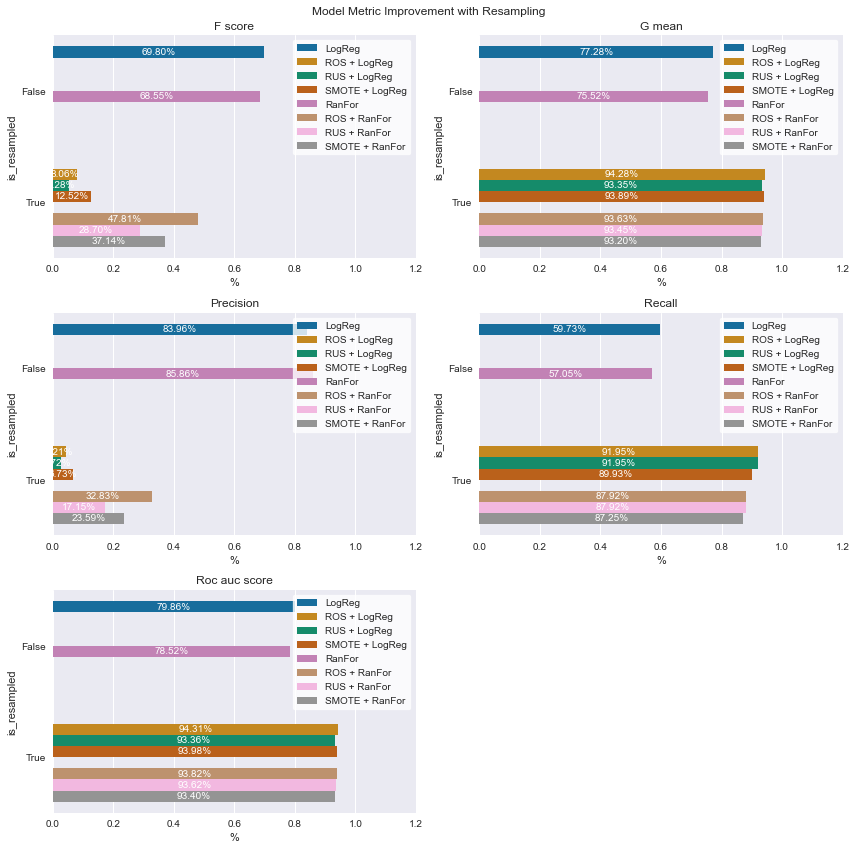

In [10]:
_ = plt.figure(figsize=[12,12])
plt.suptitle('Model Metric Improvement with Resampling')

metric_list = df_model_metric.select_dtypes(include='float64').columns

for i, metric in enumerate(metric_list):
    plt.subplot(3, 2, i+1)
    ax = sns.barplot(
        data=df_model_metric,
        x=metric,
        y='is_resampled',
        hue='exp_id',
        palette='colorblind',
        orient='h')
    for container in ax.containers:
        labels = [f'{value:.2f}%' for value in container.datavalues*100]
        ax.bar_label(container, labels, label_type='center', color='white')
    ax.set_xlabel('%')
    plt.xlim([0,1.2])
    plt.title(metric.replace('_', ' ').capitalize())
    legend = plt.legend(loc='upper right', frameon=True)
    frame = legend.get_frame()
    frame.set_color('white')
  
plt.tight_layout()

## Cross Model Metrics <a class="anchor" id="3-bullet"></a>

In [11]:
cross_data = [record['message']['data'] for record in raw_cross_data['result']]

In [12]:
df = pd.DataFrame()
for cross_record in cross_data:
    df_cross = pd.DataFrame(cross_record)
    df = pd.concat([df, df_cross], ignore_index=True)
    
assert df.shape[0] == cross_data[0].get('fit_time').__len__() * cross_data.__len__()
assert df.shape[1] == cross_data[0].__len__()

df_cross = df.melt(id_vars=['exp_id'], var_name="metrics", value_name="scores")

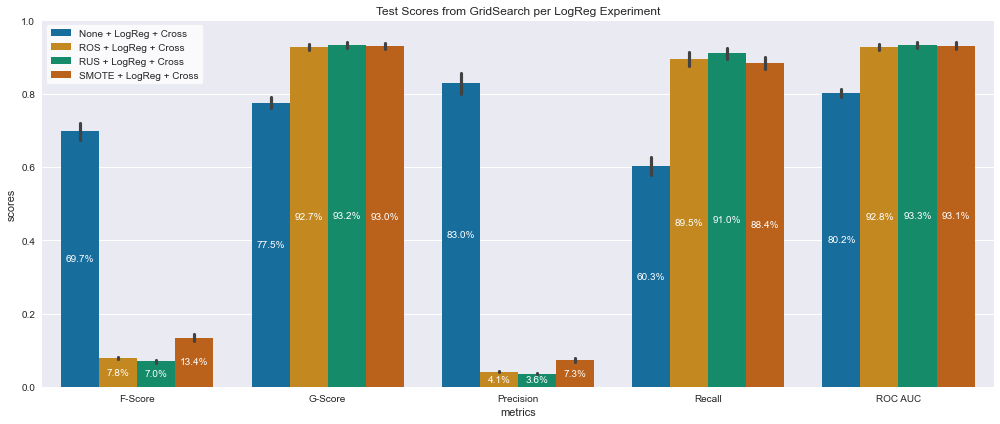

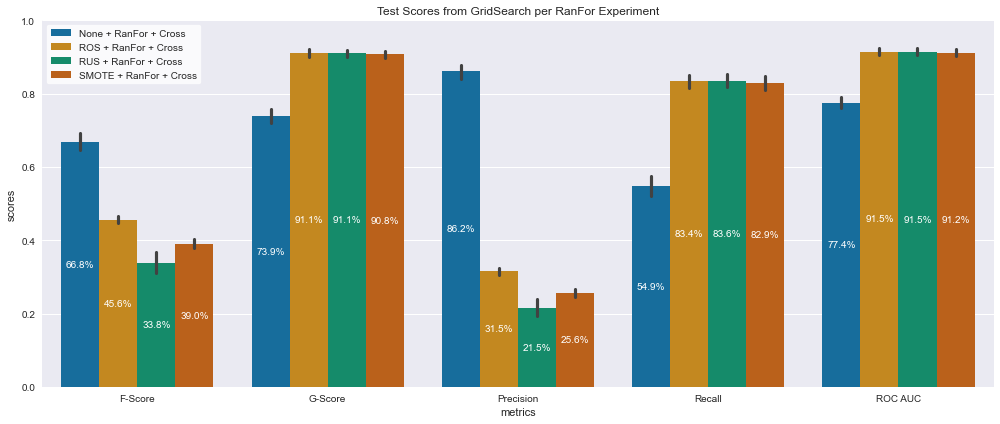

In [13]:
## LogReg
_ = plt.figure(figsize=[14,6])
exp_condition = df_cross['exp_id'].str.contains('LogReg')
metric_condition = ~((df_cross['metrics'].str.contains('fit_time')) | 
                     (df_cross['metrics'].str.contains('score_time')))
mask = exp_condition & metric_condition

ax = sns.barplot(
    data=df_cross[mask],
    x='metrics', 
    y='scores',
    hue='exp_id',
    palette='colorblind')
for container in ax.containers:
    labels = [f'{value:.1f}%' for value in container.datavalues*100]
    ax.bar_label(container, labels, label_type='center', color='white')
plt.xticks(range(5), ['F-Score', 'G-Score', 'Precision', 'Recall', 'ROC AUC'])
plt.legend(loc='upper left', frameon=True).get_frame().set_color('white')
plt.ylim([0,1])
plt.title('Test Scores from GridSearch per LogReg Experiment')
plt.tight_layout()


## RanFor
_ = plt.figure(figsize=[14,6])
exp_condition = df_cross['exp_id'].str.contains('RanFor')
metric_condition = ~((df_cross['metrics'].str.contains('fit_time')) | 
                     (df_cross['metrics'].str.contains('score_time')))
mask = exp_condition & metric_condition

ax = sns.barplot(
    data=df_cross[mask],
    x='metrics', 
    y='scores',
    hue='exp_id',
    palette='colorblind')
for container in ax.containers:
    labels = [f'{value:.1f}%' for value in container.datavalues*100]
    ax.bar_label(container, labels, label_type='center', color='white')
plt.xticks(range(5), ['F-Score', 'G-Score', 'Precision', 'Recall', 'ROC AUC'])
plt.legend(loc='upper left', frameon=True).get_frame().set_color('white')
plt.ylim([0,1])
plt.title('Test Scores from GridSearch per RanFor Experiment')
plt.tight_layout()